# Implement SVR model

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.metrics import r2_score, mean_squared_error, median_absolute_error, mean_absolute_error

from sklearn.svm import LinearSVR, SVR

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from matplotlib import pyplot as plt

from helpers import plot_variable_importance, write_metrics_in_csv, plot_ypred_vs_yreal, learning_curve_plot

In [3]:
# Open dataset
filename: str = '../dataRead_processed.pkl.bz2'
dataset: pd.DataFrame = pd.read_pickle(filename, compression='bz2')

In [4]:
# Last preprocessing steps

# Drop columns that are not needed
dataset = dataset.drop(columns=[
    'city_attraction_area',
    ])


In [5]:
# Split dataset
X = dataset.drop(columns=['total_passengers_2022'])
y = dataset['total_passengers_2022']

# Last preprocessing steps
num_features = X.select_dtypes(include=['int64', 'float64']).columns
cat_features = X.select_dtypes(include=['object', 'category']).columns

print(cat_features)

# Prepare the final preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', FunctionTransformer(lambda x: x, validate=True), num_features),
        ('cat', OneHotEncoder(), cat_features)
    ])

Index(['drg_segment', 'city_size_category', 'Dubious', 'population_category',
       'high_population'],
      dtype='object')


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [7]:
dataset.drop(columns=['total_passengers_2015'], inplace=True)

## Simple non-tuned SVR model

,Model,Hyperparameters,Mean Squared Error,Mean Absolute Error,Median Absolute Error,R2 Score
0,SVR,"{'type': 'linear', 'C': 1, 'epsilon': 0}",2.894358e+11,211675.289053,37021.943771,0.830375


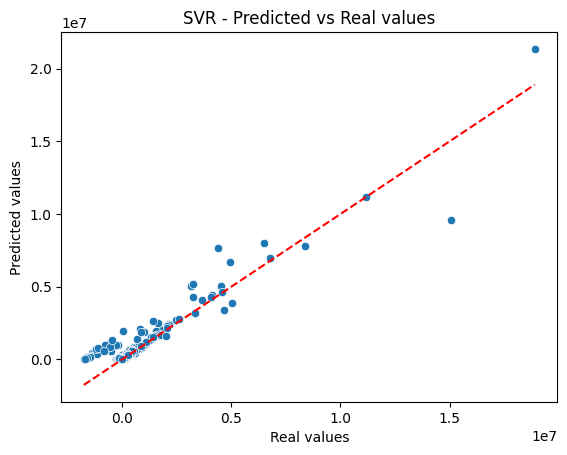

In [8]:
svm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearSVR())
])

svm.fit(X_train,y_train)
y_pred = svm.predict(X_test)

model = 'SVR'
hyperparameters = {'type': 'linear', 'C': 1, 'epsilon': 0}

plot_ypred_vs_yreal(y_test, y_pred, model, False, True)
write_metrics_in_csv(y_test, y_pred, model, hyperparameters)

In [9]:
Cs = [0.1, 1, 10, 100, 1000]
epsilons = [0, 0.1, 0.01, 0.001]

model = 'SVR'
kernel = 'linear'

for c in Cs:
    print(f'c: {c}')
    for epsilon in epsilons:
        print(f'\tepsilon: {epsilon}')
        svm = Pipeline(steps=[
                ('preprocessor', preprocessor),
                ('regressor', LinearSVR(C=c, epsilon=epsilon))
            ])
        svm.fit(X_train,y_train)
        y_pred = svm.predict(X_test)
        hyperparameters = {
            'type': kernel,
            'C': c,
            'epsilon': epsilon
        }
        write_metrics_in_csv(y_test, y_pred, model, hyperparameters)
        


c: 0.1
	epsilon: 0
	epsilon: 0.1
	epsilon: 0.01
	epsilon: 0.001
c: 1
	epsilon: 0
	epsilon: 0.1
	epsilon: 0.01
	epsilon: 0.001
c: 10
	epsilon: 0
	epsilon: 0.1
	epsilon: 0.01
	epsilon: 0.001
c: 100
	epsilon: 0
	epsilon: 0.1
	epsilon: 0.01
	epsilon: 0.001
c: 1000
	epsilon: 0
	epsilon: 0.1
	epsilon: 0.01
	epsilon: 0.001


In [22]:
param_grid = {
    'regressor__C': [0.1, 1, 10, 100],
    'regressor__epsilon': [0.01, 0.1, 0.2, 0.5, 1],
    'regressor__kernel': ['rbf', 'poly'],
    'regressor__degree': [1, 2, 3],
}

svm = Pipeline(steps=[
                ('preprocessor', preprocessor),
                ('regressor', SVR())
            ])
grid_search = GridSearchCV(svm, param_grid, cv=5, verbose=10, n_jobs = -1, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print("Best hyperparameters:", grid_search.best_params_)
# Train the SVR model with the best hyperparameters
best_svr = grid_search.best_estimator_
best_svr.fit(X_train, y_train)

# Make predictions
y_pred_best_svr = best_svr.predict(X_test)


Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV 3/5; 1/120] START regressor__C=0.1, regressor__degree=1, regressor__epsilon=0.01, regressor__kernel=rbf
[CV 5/5; 1/120] START regressor__C=0.1, regressor__degree=1, regressor__epsilon=0.01, regressor__kernel=rbf
[CV 2/5; 1/120] START regressor__C=0.1, regressor__degree=1, regressor__epsilon=0.01, regressor__kernel=rbf
[CV 4/5; 1/120] START regressor__C=0.1, regressor__degree=1, regressor__epsilon=0.01, regressor__kernel=rbf
[CV 1/5; 1/120] START regressor__C=0.1, regressor__degree=1, regressor__epsilon=0.01, regressor__kernel=rbf
[CV 2/5; 2/120] START regressor__C=0.1, regressor__degree=1, regressor__epsilon=0.01, regressor__kernel=poly
[CV 1/5; 2/120] START regressor__C=0.1, regressor__degree=1, regressor__epsilon=0.01, regressor__kernel=poly
[CV 5/5; 1/120] END regressor__C=0.1, regressor__degree=1, regressor__epsilon=0.01, regressor__kernel=rbf;, score=-4925024908660.423 total time=   0.1s
[CV 3/5; 2/120] START regre

,Model,Hyperparameters,Mean Squared Error,Mean Absolute Error,Median Absolute Error,R2 Score
0,SVR,"{'regressor__C': 100, 'regressor__degree': 3, ...",1.474315e+12,334737.229536,39657.146749,-33.238075


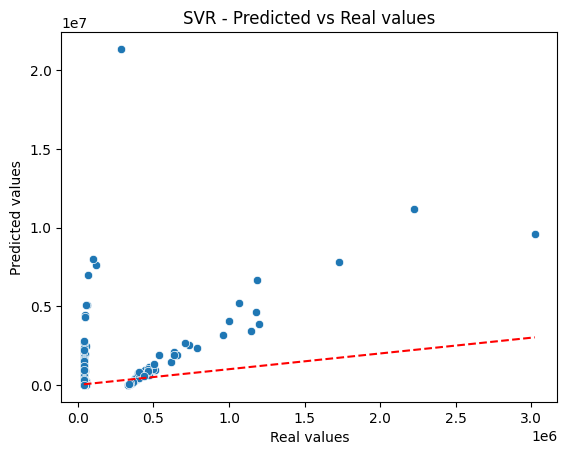

In [23]:
plot_ypred_vs_yreal(y_test, y_pred_best_svr, model, False, True)
write_metrics_in_csv(y_test, y_pred_best_svr, model, grid_search.best_params_)

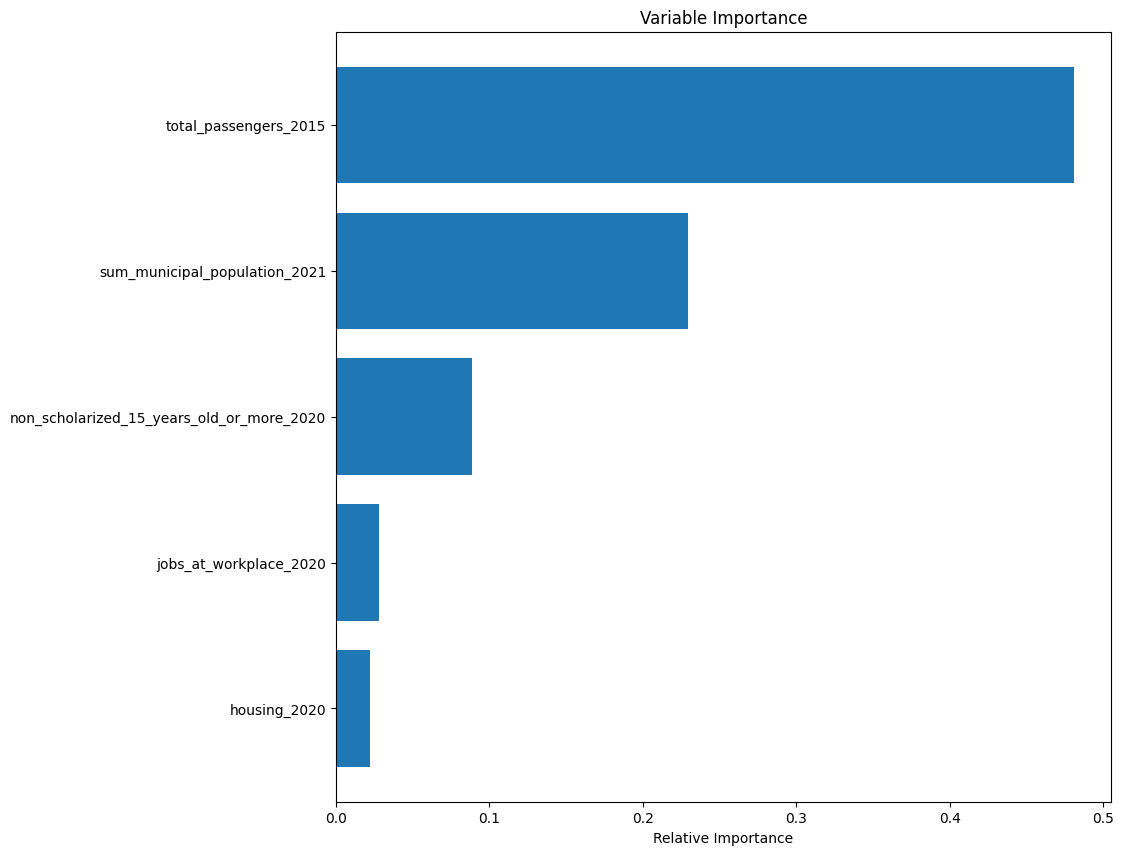

In [20]:
plot_variable_importance(best_svr, X_train, y_train, 5)

### Alternative to `grid_search.best_estimator_`

In [12]:
# Alternative to train/test the best model
best_parameters = grid_search.best_params_

svm = Pipeline(steps=[
                ('preprocessor', preprocessor),
                ('regressor', SVR(C=best_parameters['regressor__C'],
          epsilon=best_parameters['regressor__epsilon']))
            ])

# Train the model
svm.fit(X_train, y_train)

# Make predictions
y_pred = svm.predict(X_test)


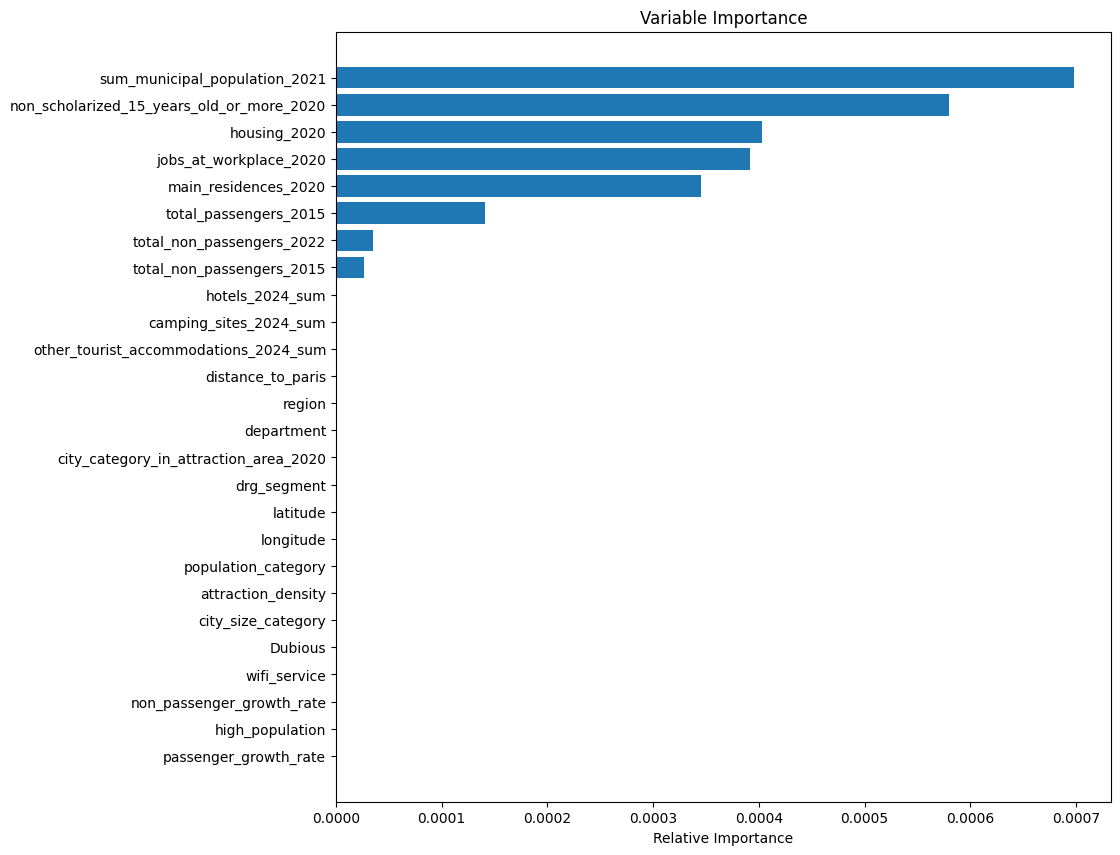

In [13]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(best_svr, X_test, y_test, n_repeats=30, random_state=42)
feature_importance = perm_importance.importances_mean
sorted_idx = np.argsort(feature_importance)

pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()